In [1]:
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import sys
from datetime import datetime
from scipy.optimize import curve_fit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# RUN="14180"
# RUN="13850"
# RUN="13859"
# RUN="14498"
RUN="14780"

# Argon Runs
if (RUN == "14180" or RUN == "13850"):
    cathode_cut = 797
    nbins = 10
    bound_params = 6.25e5, 0.5e6, 250 
    q0_low = 2.5e3
    low_charge_lim = 1e7
    max_bin_shift = 0.015e7

elif (RUN == "13859"):
    cathode_cut = 755
    nbins = 10
    bound_params = 6.25e5, 0.6e6, 1500 
    q0_low = 2.5e3
    low_charge_lim = 1e7
    max_bin_shift = 0.015e7

# Xenon Runs
elif (RUN == "14498"):
    cathode_cut = 1275
    nbins = 10
    bound_params = 6.25e5, 0.5e6, 250 
    q0_low = 2.5e3
    low_charge_lim = 1e7
    max_bin_shift = 0.015e7


elif (RUN == "14780"):
    cathode_cut = 1275
    nbins = 10
    bound_params = 6.25e5, 0.5e6, 250 
    q0_low = 2.5e3
    low_charge_lim = 1e7
    max_bin_shift = 0.025e7

print("The run is:", RUN)

The run is: 14780


In [5]:
file = f"../data/analysis/Run_{RUN}_Filtered.h5"

# Load the data
data_properties = pd.read_hdf(file, "data_properties")

# Convert 'event' columns to integers
data_properties['event'] = data_properties['event'].astype(int)

# Get event_ids where 'x' or 'y' has NaN values
nan_event_ids = data_properties[data_properties['x'].isna()]['event'].values
nan_event_ids = np.append(nan_event_ids, data_properties[data_properties['y'].isna()]['event'].values)

nan_event_ids = np.append(nan_event_ids, data_properties[data_properties['cath_time'].isna()]['event'].values)

# Filter out rows in data and data_properties based on the 'event' column
data_properties = data_properties[~data_properties['event'].isin(nan_event_ids)]

# data_properties["S2_area"] = data_properties["S2_areafit"]

# Check if there are still NaN values
print(data_properties.isna().sum())

display(data_properties)
print(len(data_properties.event.unique()))

event              0
S2_area            0
S2_areafit         0
S2_time            0
cath_area          0
cath_time          0
cath_std           6
ts_raw             0
deltaT             0
sigma              0
S2_amp             0
x                  0
y                  0
grass_peaks        0
nS1                0
mean_interp_amp    0
std_interp_amp     0
ts                 0
dtype: int64


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,nS1,mean_interp_amp,std_interp_amp,ts
0,195806,1.864288e+06,1.891039e+06,1608.631760,335.670562,2543.691667,37.807753,1.738347e+09,1217.975,6.142186,1.349984e+05,257.775,368.825,0,1,11.463021,9.807686,2025-01-31 12:14:31.260
1,195813,1.628630e+07,1.668758e+07,1606.952016,227.202560,2555.748214,23.134339,1.738347e+09,170.875,2.590299,2.513913e+06,396.725,122.025,0,1,-143.761745,607.486393,2025-01-31 12:14:31.604
2,195820,1.990246e+07,1.978778e+07,1614.266302,1066.971043,2558.081818,30.009613,1.738347e+09,996.650,5.689040,1.405687e+06,-3.575,-170.925,0,1,113.025869,82.647522,2025-01-31 12:14:32.050
3,195827,1.643937e+07,1.633932e+07,1614.919970,1051.386956,2554.347368,30.625936,1.738347e+09,1350.050,6.434684,1.024212e+06,212.125,-263.225,0,1,108.731836,74.360131,2025-01-31 12:14:32.470
4,195834,4.006375e+06,4.000907e+06,1611.567298,229.745535,2540.197500,34.231627,1.738347e+09,849.900,5.393579,3.071014e+05,-343.675,-294.825,0,1,29.169689,19.343553,2025-01-31 12:14:32.774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,88608,2.776506e+06,2.974702e+06,1607.050603,709.602227,2570.468421,36.101040,1.738342e+09,428.950,7.350764,1.447018e+05,412.275,-62.575,1,1,140.663966,96.758577,2025-01-31 10:40:18.170
59,88615,1.867100e+06,2.262807e+06,1605.641811,250.042594,2547.568000,30.059962,1.738342e+09,-999.000,12.391000,7.788956e+04,304.425,184.225,1,2,146.217020,101.299677,2025-01-31 10:40:18.556
60,88622,1.896021e+07,1.898838e+07,1618.313275,912.363628,2552.725000,22.926821,1.738342e+09,1348.775,7.074120,1.080989e+06,443.375,-48.025,0,1,133.946457,92.606833,2025-01-31 10:40:19.186
61,88629,5.253151e+06,5.233413e+06,1613.070569,532.498576,2543.613158,19.137281,1.738342e+09,1349.475,6.464234,3.377012e+05,-265.925,-78.125,0,1,37.986093,26.273507,2025-01-31 10:40:19.490


30511


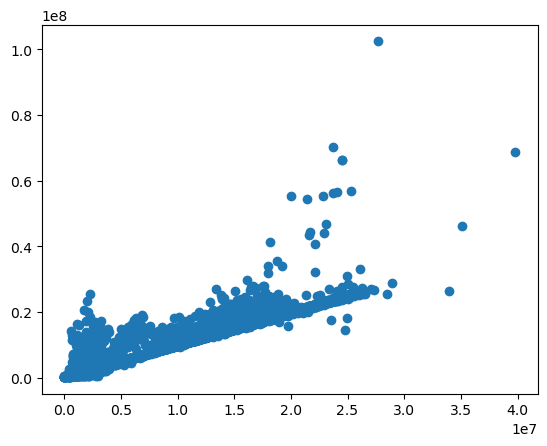

In [6]:
plt.figure()
plt.scatter(data_properties.S2_area, data_properties.S2_areafit)

In [7]:
# Rebin the x and y

# Define bin edges using np.linspace for x and y
x_bins = np.linspace(-500, 500, nbins)  # 10 evenly spaced bins between -500 and 500
y_bins = np.linspace(-500, 500, nbins)

# Bin the x and y columns
data_properties['x_bin'] = pd.cut(data_properties['x'], bins=x_bins, labels=False)  # Labels as index (0, 1, 2,...)
data_properties['y_bin'] = pd.cut(data_properties['y'], bins=y_bins, labels=False)

# Calculate bin centers
x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2  # Bin centers for x
y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers for y

print(data_properties['x_bin'].unique())
print(len(data_properties['x_bin'].unique()))

# Assign the bin centers as new columns
data_properties['x_bin_center'] = data_properties['x_bin'].map(lambda i: x_bin_centers[i] if pd.notna(i) else np.nan)
data_properties['y_bin_center'] = data_properties['y_bin'].map(lambda i: y_bin_centers[i] if pd.notna(i) else np.nan)

# Assign a unique bin ID for each (x_bin, y_bin) pair
data_properties['bin_id'] = data_properties['x_bin'].astype(str) + '_' + data_properties['y_bin'].astype(str)

display(data_properties)

[6 8 4 1 2 7 5 3 0]
9


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,grass_peaks,nS1,mean_interp_amp,std_interp_amp,ts,x_bin,y_bin,x_bin_center,y_bin_center,bin_id
0,195806,1.864288e+06,1.891039e+06,1608.631760,335.670562,2543.691667,37.807753,1.738347e+09,1217.975,6.142186,...,0,1,11.463021,9.807686,2025-01-31 12:14:31.260,6,7,222.222222,333.333333,6_7
1,195813,1.628630e+07,1.668758e+07,1606.952016,227.202560,2555.748214,23.134339,1.738347e+09,170.875,2.590299,...,0,1,-143.761745,607.486393,2025-01-31 12:14:31.604,8,5,444.444444,111.111111,8_5
2,195820,1.990246e+07,1.978778e+07,1614.266302,1066.971043,2558.081818,30.009613,1.738347e+09,996.650,5.689040,...,0,1,113.025869,82.647522,2025-01-31 12:14:32.050,4,2,0.000000,-222.222222,4_2
3,195827,1.643937e+07,1.633932e+07,1614.919970,1051.386956,2554.347368,30.625936,1.738347e+09,1350.050,6.434684,...,0,1,108.731836,74.360131,2025-01-31 12:14:32.470,6,2,222.222222,-222.222222,6_2
4,195834,4.006375e+06,4.000907e+06,1611.567298,229.745535,2540.197500,34.231627,1.738347e+09,849.900,5.393579,...,0,1,29.169689,19.343553,2025-01-31 12:14:32.774,1,1,-333.333333,-333.333333,1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,88608,2.776506e+06,2.974702e+06,1607.050603,709.602227,2570.468421,36.101040,1.738342e+09,428.950,7.350764,...,1,1,140.663966,96.758577,2025-01-31 10:40:18.170,8,3,444.444444,-111.111111,8_3
59,88615,1.867100e+06,2.262807e+06,1605.641811,250.042594,2547.568000,30.059962,1.738342e+09,-999.000,12.391000,...,1,2,146.217020,101.299677,2025-01-31 10:40:18.556,7,6,333.333333,222.222222,7_6
60,88622,1.896021e+07,1.898838e+07,1618.313275,912.363628,2552.725000,22.926821,1.738342e+09,1348.775,7.074120,...,0,1,133.946457,92.606833,2025-01-31 10:40:19.186,8,4,444.444444,0.000000,8_4
61,88629,5.253151e+06,5.233413e+06,1613.070569,532.498576,2543.613158,19.137281,1.738342e+09,1349.475,6.464234,...,0,1,37.986093,26.273507,2025-01-31 10:40:19.490,2,3,-222.222222,-111.111111,2_3


In [8]:
print(len(nan_event_ids))
data_properties.describe()
tc=25e-3

0


Text(0.5, 1.0, 'RUN 14780')

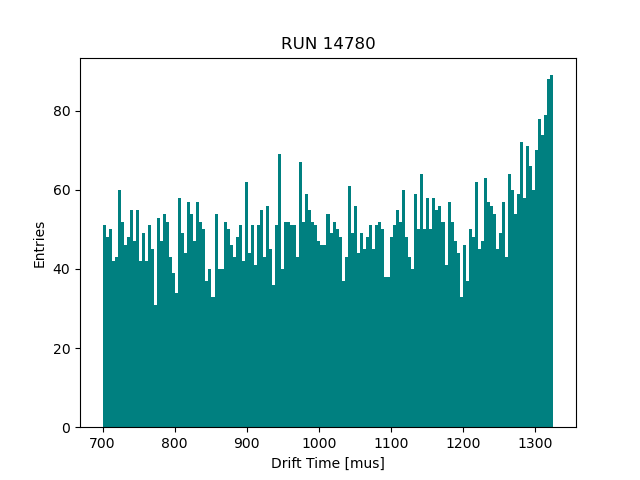

In [9]:
%matplotlib widget
plt.figure()

plt.hist(data_properties.deltaT, bins = np.linspace(700, cathode_cut+50, 150), color = "Teal");
plt.xlabel("Drift Time [mus]")
plt.ylabel("Entries")
plt.title(f"RUN {RUN}")


False


Text(0, 0.5, 'Y [mm]')

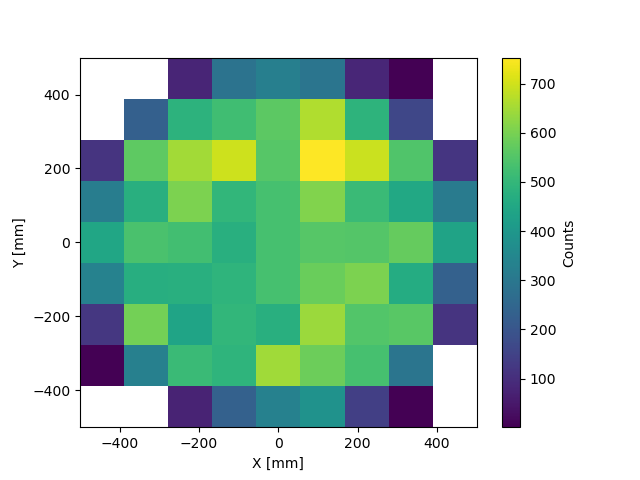

In [10]:
%matplotlib widget
fig, ax = plt.subplots()
has_nan = data_properties['x'].isna().any()
print(has_nan)

hist, xedges, yedges = np.histogram2d(data_properties.x, data_properties.y, bins=[np.linspace(-500,500,nbins),np.linspace(-500,500,nbins)])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")



In [11]:
data_properties_active = data_properties[ (data_properties.deltaT > 0) & (data_properties.deltaT < cathode_cut)]

data_properties_active = data_properties_active[data_properties_active["S2_area"] < 3e7]

5_4 18.57465906310163 51.05756934994226


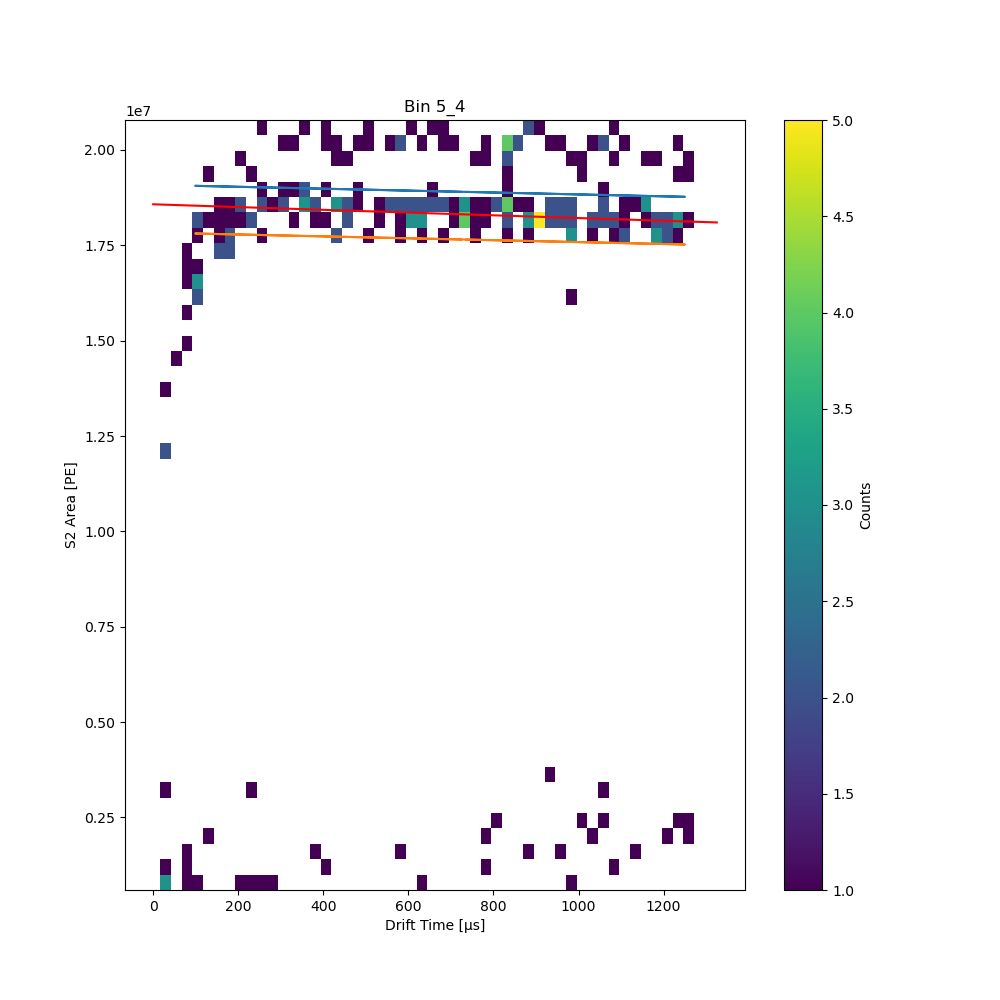

In [12]:
# Define the exponential decay function
def exp_decay(t, q, tau):
    if (tau == 0):
        return np.ones(len(t))
    else:
        return q * np.exp(-t / tau)

def FitLifetime(df, binid):

    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == binid] 

    # Get the histogram with the most counts to find the main alpha peak
    counts, bin_edges = np.histogram(df_bin.S2_area, bins=50) 
    max_bin_index = np.argmax(counts)  # Index of the bin with the most counts
    max_bin_value = bin_edges[max_bin_index]  # Left edge of the bin with the most counts

    lower_bound = max_bin_value-bound_params[0] + bound_params[1]
    upper_bound = max_bin_value+bound_params[0] + bound_params[1]

    # print("Max bin value is:", max_bin_value)
    # print("Lower/upper bound is:", lower_bound, upper_bound)

    df_bin = df_bin[ (df_bin.S2_area > -bound_params[2]*df_bin.deltaT+lower_bound) & (df_bin.S2_area < -bound_params[2]*df_bin.deltaT+upper_bound)  ]

    if (len(df_bin) < 15):
        return 0, 0

    # Make 2D hist for binning
    hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=100)

    t = np.linspace(0,cathode_cut+50,300)
    plt.plot(df_bin['deltaT'], -bound_params[2]*df_bin.deltaT+upper_bound) # if you want to plot the bands plot this. 
    plt.plot(df_bin['deltaT'], -bound_params[2]*df_bin.deltaT+lower_bound)
    
    # Perform the curve fit
    params, covariance = curve_fit(exp_decay, df_bin.deltaT, df_bin.S2_area, bounds = ([q0_low, 1e3], [2.3e7, 150e3]))


    # Extract the fitted parameters
    q_fit, tau_fit = params
    print(binid, q_fit/1e6, tau_fit/1e3 )

    return q_fit, tau_fit

fig, ax = plt.subplots(1, 1, figsize=(nbins, nbins))

# Filter data based on the current bin_id
bin_ = "5_4"
df_bin = data_properties_active[data_properties_active.bin_id == bin_] # 4_5, 

# Create 2D histogram
hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=50)

# Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# Custom colormap
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# Plot with pcolormesh
pcm = ax.pcolormesh(x_edges, y_edges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

# Set labels
ax.set_xlabel("Drift Time [μs]")
ax.set_ylabel("S2 Area [PE]")
ax.set_title(f"Bin {bin_}")
# ax.set_ylim(2.5e8,4.5e8)

# # Generate fitted curve
t_fit = np.linspace(0, cathode_cut+50, 100)

q_fit, tau_fit = FitLifetime(data_properties_active, bin_)
hist_fit = exp_decay(t_fit, q_fit, tau_fit)

# # Plotting the fitted exponential decay curve
ax.plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')



/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_61641/2790404921.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis").copy()


3_8 15.483680932019658 71.79256165740196
4_8 15.8918309099227 149.99999999999997
5_8 14.681700218005364 101.04945745334331
1_7 16.96752437789565 54.48963223822501
2_7 17.41137982966804 37.53174373628549
3_7 17.707973270590866 60.8128445457597
4_7 17.855077290027815 56.15322124425877
5_7 17.767477802284716 63.775040299464436
6_7 16.30046095367045 72.95354882685999
7_7 15.122557010338555 149.99999999998477
1_6 17.34550497036726 149.9999999995311
2_6 17.900919639090365 82.61508136884495
3_6 18.309228909757845 56.22995686295813
4_6 18.491256132973795 37.89022653158349
5_6 18.17258462417355 46.695683914160846
6_6 17.109902470642872 81.69510489461187
7_6 16.52789464021973 96.32445868352144
0_5 16.14702796505892 76.6182139541617
1_5 17.498280358822974 60.024303229874896
2_5 18.30502372788882 56.72504689385365
3_5 18.385894566107424 63.586682904353026
4_5 18.571895214589286 57.16344823509973
5_5 18.450242785574314 74.28284205632978
6_5 18.196126333778267 54.87200181235305
7_5 17.77907795196181

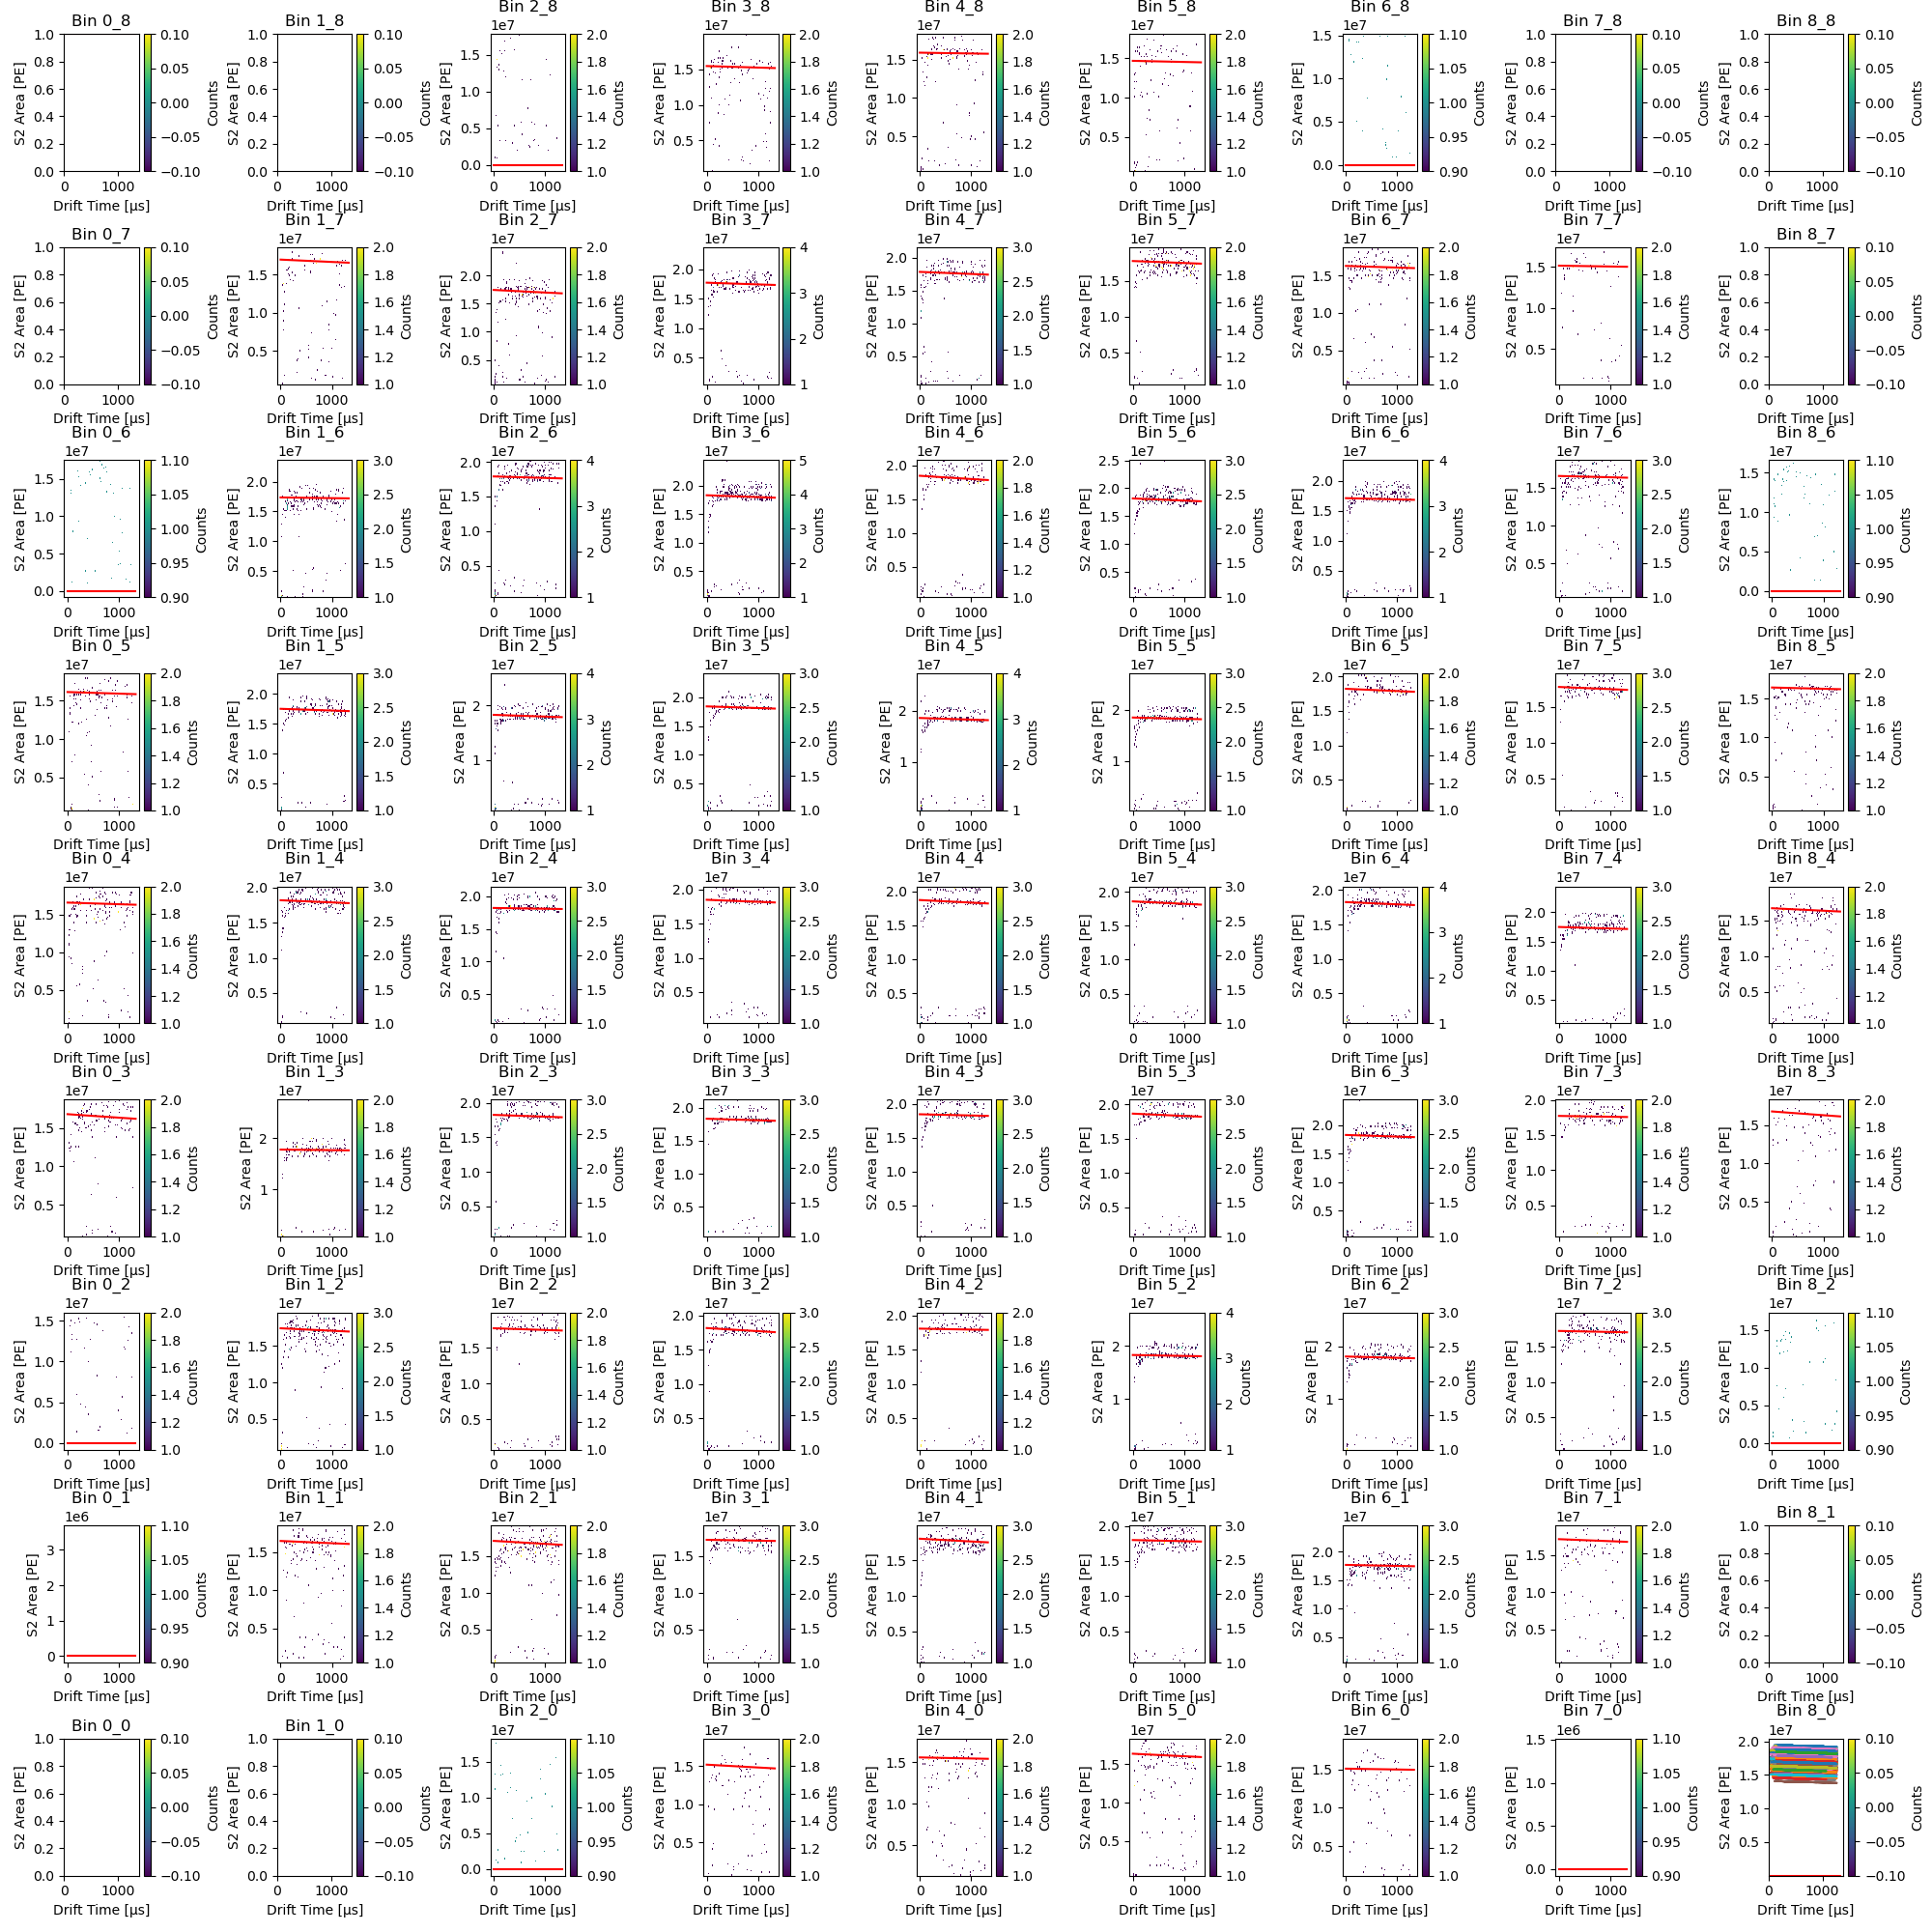

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_61641/2790404921.py:84: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['bin_id', 'lt', 'q0'], dtype='object')]

  lifetime_df.to_hdf(f"../maps/LifetimeMap_Run_{RUN}.h5", key='map', mode='w')


In [41]:
# Make a plot of the time vs peak width

data_properties_active['sigma'] = data_properties_active['sigma'].fillna(0)
data_properties_active['S2_amp'] = data_properties_active['S2_amp'].fillna(-1)
data_properties_active = data_properties_active[data_properties_active.S2_amp > 0]

data_properties['sigma'] = data_properties['sigma'].fillna(0)
data_properties['S2_amp'] = data_properties['S2_amp'].fillna(-1)
data_properties = data_properties[data_properties.S2_amp > 0]


# Define the plot function
def plot_lifetime(ax, df, S2var, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(df_bin['deltaT'], df_bin[S2var], bins=100)

    # Mask zero bins
    masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

    # Custom colormap
    # cmap = plt.cm.viridis
    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='white')  # Set masked values (zeros) to white

    # Plot with pcolormesh
    pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

    # Add color bar
    plt.colorbar(pcm, ax=ax, label='Counts')

    # Set labels
    ax.set_xlabel("Drift Time [μs]")
    ax.set_ylabel("S2 Area [PE]")
    ax.set_title(f"Bin {bin_id}")
    # ax.set_ylim(2.5e8,4.5e8)


# Create a grid of subplots (5x5)
fig, axs = plt.subplots(nbins-1, nbins-1, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(nbins-2, -1, -1):
    for x in range(0, nbins-1, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        
        plot_lifetime(axs[counter], data_properties_active, "S2_area",f"{x}_{y}")

        t_fit = np.linspace(0, cathode_cut+50, 100)

        q_fit, tau_fit = FitLifetime(data_properties_active, f"{x}_{y}")
        hist_fit = exp_decay(t_fit, q_fit, tau_fit)

        # # Plotting the fitted exponential decay curve
        axs[counter].plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')

        # Create a new DataFrame to append
        new_data = pd.DataFrame({
            "bin_id": [f"{x}_{y}"],
            "lt": [tau_fit],
            "q0": [q_fit]
        })

        lifetime_df = pd.concat([lifetime_df, new_data], ignore_index=True)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

# lifetime_df.loc[lifetime_df['lt'] > 99e3, 'lt'] = 0

# Save the calibration map
lifetime_df.to_hdf(f"../maps/LifetimeMap_Run_{RUN}.h5", key='map', mode='w')


,bin_id,lt,q0,x_center,y_center
0,0_8,0,0,-444.444444,444.444444
1,1_8,0,0,-333.333333,444.444444
2,2_8,0,0,-222.222222,444.444444
3,3_8,71792.561657,15483680.93202,-111.111111,444.444444
4,4_8,150000.0,15891830.909923,0.000000,444.444444
...,...,...,...,...,...
76,4_0,122435.945733,15588159.529891,0.000000,-444.444444
77,5_0,49473.927159,16390706.267026,111.111111,-444.444444
78,6_0,136858.13063,15086567.941556,222.222222,-444.444444
79,7_0,0,0,333.333333,-444.444444


Text(0.5, 1.0, '14780 Q0')

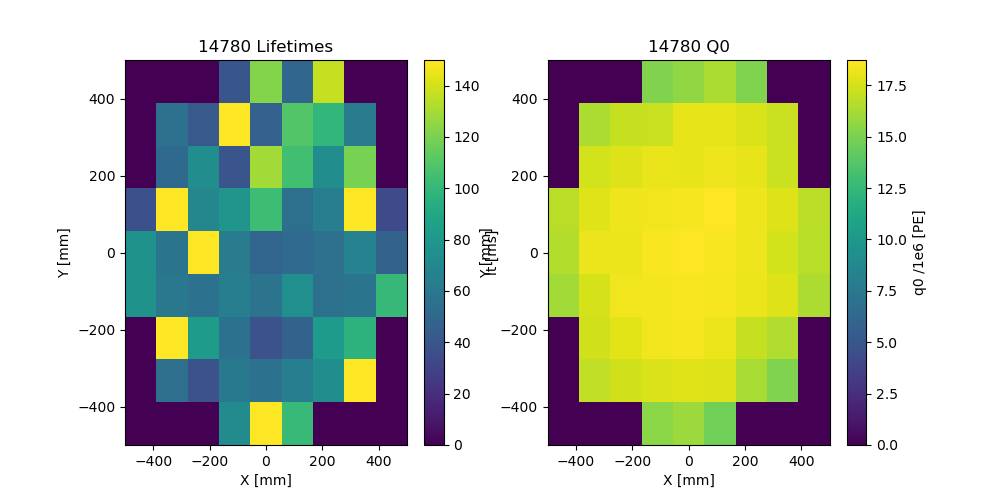

In [43]:
%matplotlib widget

display(lifetime_df)

# Function to extract x and y positions from bin_id
def get_bin_position_from_id(bin_id, x_bin_centers, y_bin_centers):
    try:
        x_bin, y_bin = map(int, bin_id.split('_'))  # Split and convert bin_id to integers
        return x_bin_centers[x_bin], y_bin_centers[y_bin]
    except (ValueError, IndexError) as e:
        return np.nan, np.nan  # Return NaN if there's an issue with the bin_id

# Apply the function to create new columns
lifetime_df_pos= lifetime_df
lifetime_df_pos[['x_center', 'y_center']] = lifetime_df['bin_id'].apply(
    lambda bid: pd.Series(get_bin_position_from_id(bid, x_bin_centers, y_bin_centers))
)


lifetime_df_pos.loc[lifetime_df_pos['lt'] > 200e3, 'lt'] = 0

# Create pivot table to reshape the data for 2D plotting
lt_pivot = lifetime_df_pos.pivot(index='y_center', columns='x_center', values='lt')

# Sort the axes (necessary if bin centers are not in order)
lt_pivot = lt_pivot.sort_index(ascending=False)  # y-axis usually goes from top to bottom
lt_pivot = lt_pivot.astype(float).fillna(0) 

# Create pivot table to reshape the data for 2D plotting
q0_pivot = lifetime_df_pos.pivot(index='y_center', columns='x_center', values='q0')

# Sort the axes (necessary if bin centers are not in order)
q0_pivot = q0_pivot.sort_index(ascending=False)  # y-axis usually goes from top to bottom
q0_pivot = q0_pivot.astype(float).fillna(0) 


# Plotting using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the pcolormesh plot
c = axs[0].pcolormesh(x_bins, y_bins, lt_pivot / 1e3, cmap='viridis', shading='auto')
fig.colorbar(c, ax=axs[0], label='lt [ms]')  # Specify 'ax' to link the color bar to the plot
axs[0].set_xlabel('X [mm]')
axs[0].set_ylabel('Y [mm]')
axs[0].set_title(f'{RUN} Lifetimes')


c = axs[1].pcolormesh(x_bins, y_bins, q0_pivot / 1e6, cmap='viridis', shading='auto')
fig.colorbar(c, ax=axs[1], label='q0 /1e6 [PE]')  # Specify 'ax' to link the color bar to the plot
axs[1].set_xlabel('X [mm]')
axs[1].set_ylabel('Y [mm]')
axs[1].set_title(f'{RUN} Q0')


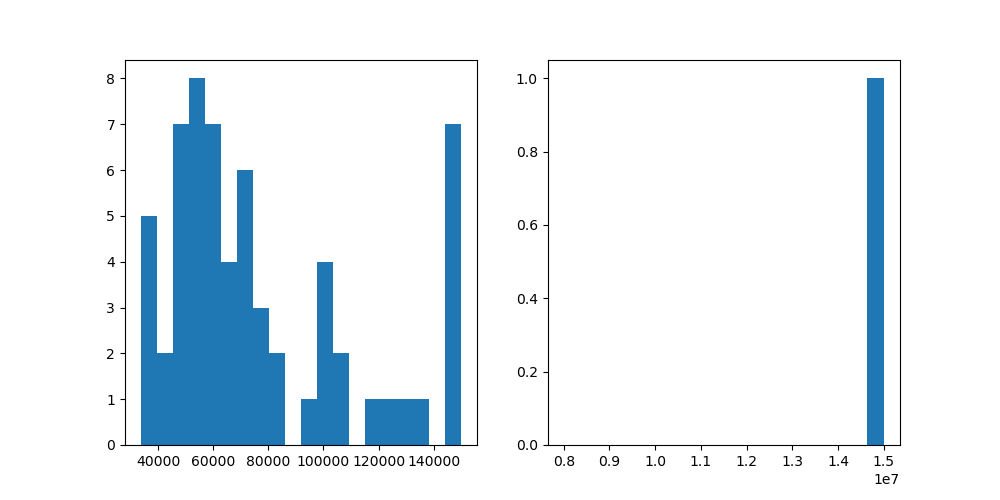

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(lifetime_df[lifetime_df["lt"] > 0]["lt"], bins =20);
axs[1].hist(lifetime_df[lifetime_df["q0"] > 0]["q0"], bins =np.linspace(0.8e7,1.5e7,20));

In [45]:
# Plot the alpha map of

def CorrectLifetime(row, var, q0_max):

    lt = row["lt"]
    time = row["deltaT"]
    q0 = row["q0"]

    if (q0 == 0):
        q_corr = 1
    else:
        q_corr = q0_max/q0


    if (lt == 0):
        return 0
    else:
        return q_corr * row[var] / np.exp(-1*time/lt)

def CorrectLifetimeAvg(row, var, t, mean_lt):

    time = row[t]

    if (mean_lt == 0):
        return 1
    else:
        return row[var] / np.exp(-1*time/mean_lt)



mean_lt = np.mean (lifetime_df[ (lifetime_df["lt"] > 0) & (lifetime_df["lt"] < 100e3)]["lt"])
print("Mean Lifetime is:", mean_lt/1e3, " ms")

data_properties_active_lt = pd.merge(data_properties_active, lifetime_df, on="bin_id", how="left")
q0_max = np.max(data_properties_active_lt.q0)
data_properties_active_lt["S2_areaC"] = data_properties_active_lt.apply(lambda row: CorrectLifetime(row, "S2_area", q0_max), axis=1)
data_properties_active_lt["R"] = np.sqrt(data_properties_active_lt["x"]*data_properties_active_lt["x"] + data_properties_active_lt["y"]*data_properties_active_lt["y"])

data_properties_lt = pd.merge(data_properties, lifetime_df, on="bin_id", how="left")
q0_max = np.max(data_properties_lt.q0)
data_properties_lt["S2_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetime(row,"S2_area", q0_max), axis=1)
data_properties_lt["R"] = np.sqrt(data_properties_lt["x"]*data_properties_lt["x"] + data_properties_lt["y"]*data_properties_lt["y"])

data_properties_lt["cath_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetime(row,"cath_area", q0_max), axis=1)
# data_properties_lt["cath_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetimeAvg(row,"cath_area", "deltaT",  mean_lt), axis=1)

nan_event_ids = data_properties_lt[data_properties_lt['R'].isna()]['event'].values
print(nan_event_ids)

display(data_properties_active_lt)


Mean Lifetime is: 59.8018466626138  ms
[]


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,y_bin,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R
0,195806,1.864288e+06,1.891039e+06,1608.631760,335.670562,2543.691667,37.807753,1.738347e+09,1217.975,6.142186,...,7,222.222222,333.333333,6_7,72953.548827,16300460.95367,222.222222,333.333333,2.178682e+06,449.977590
1,195813,1.628630e+07,1.668758e+07,1606.952016,227.202560,2555.748214,23.134339,1.738347e+09,170.875,2.590299,...,5,444.444444,111.111111,8_5,100574.161595,16424953.899536,444.444444,111.111111,1.860742e+07,415.067255
2,195820,1.990246e+07,1.978778e+07,1614.266302,1066.971043,2558.081818,30.009613,1.738347e+09,996.650,5.689040,...,2,0.000000,-222.222222,4_2,129298.887466,18052998.866474,0.000000,-222.222222,2.081301e+07,170.962383
3,195834,4.006375e+06,4.000907e+06,1611.567298,229.745535,2540.197500,34.231627,1.738347e+09,849.900,5.393579,...,1,-333.333333,-333.333333,1_1,55237.67922,16437088.286627,-333.333333,-333.333333,4.637019e+06,452.807118
4,195848,1.374028e+06,1.475990e+06,1601.760761,147.242841,2529.340000,28.672040,1.738347e+09,29.725,5.982760,...,2,-222.222222,-222.222222,2_2,73238.126896,17743380.936438,-222.222222,-222.222222,1.451328e+06,302.470736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14930,88552,1.682964e+07,1.702723e+07,1608.718857,834.152974,2546.663158,29.859192,1.738342e+09,237.575,2.963583,...,2,-333.333333,-222.222222,1_2,50859.481026,17445433.89356,-333.333333,-222.222222,1.815732e+07,398.402850
14931,88566,1.702935e+07,1.692350e+07,1616.411981,455.378217,2549.158065,20.562292,1.738342e+09,1247.925,6.504747,...,4,333.333333,0.000000,7_4,66506.366871,17483983.18576,333.333333,0.000000,1.859246e+07,352.573795
14932,88587,1.886410e+07,1.891486e+07,1611.026035,444.169846,2546.348387,24.847797,1.738342e+09,453.775,3.796523,...,6,111.111111,222.222222,5_6,46695.683914,18172584.624174,111.111111,222.222222,1.963675e+07,300.540731
14933,88594,1.933969e+07,1.911483e+07,1615.139968,1206.770256,2544.473171,24.738663,1.738342e+09,1101.525,5.969422,...,3,222.222222,-111.111111,6_3,63203.163574,18258134.665693,222.222222,-111.111111,2.019259e+07,251.270484


In [46]:
data_properties_active_lt.describe()

,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,std_interp_amp,ts,x_bin,y_bin,x_bin_center,y_bin_center,x_center,y_center,S2_areaC,R
count,14935.000000,1.493500e+04,1.493500e+04,14935.000000,14935.000000,14935.000000,14934.000000,1.493500e+04,14935.000000,14935.000000,...,14935.000000,14935,14935.000000,14935.000000,14935.000000,14935.000000,14935.000000,14935.000000,1.493500e+04,14935.000000
mean,123793.545698,1.497737e+07,1.518717e+07,1611.167784,875.435768,2549.687848,27.020319,1.738343e+09,636.238318,4.739259,...,243.926106,2025-01-31 11:11:17.311302144,4.000067,3.988751,0.007440,-1.249861,0.007440,-1.249861,1.578483e+07,315.922110
min,2.000000,3.824015e+05,3.720614e+05,1590.000000,-5.300385,2501.764982,0.010992,1.738337e+09,0.500000,-0.974109,...,4.948995,2025-01-31 09:22:49.819000,0.000000,0.000000,-444.444444,-444.444444,-444.444444,-444.444444,0.000000e+00,3.680523
25%,63243.500000,1.500675e+07,1.528591e+07,1608.437945,286.808775,2543.546121,24.113269,1.738340e+09,305.800000,3.493905,...,68.041615,2025-01-31 10:18:03.070499840,2.000000,2.000000,-222.222222,-222.222222,-222.222222,-222.222222,1.675022e+07,236.221160
50%,121564.000000,1.726369e+07,1.737056e+07,1611.804327,459.538612,2549.598529,27.568995,1.738343e+09,638.200000,4.739355,...,79.706976,2025-01-31 11:09:04.972999936,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.849343e+07,332.337804
75%,186853.000000,1.820251e+07,1.825900e+07,1614.288674,695.774374,2555.929349,30.580884,1.738347e+09,964.775000,5.704779,...,248.163615,2025-01-31 12:06:33.056999936,6.000000,6.000000,222.222222,222.222222,222.222222,222.222222,1.912964e+07,411.267135
max,250042.000000,2.766707e+07,1.024880e+08,1638.702842,147874.534860,2598.072778,44.883164,1.738350e+09,1274.775000,20.879935,...,5388.787837,2025-01-31 13:02:31.944000,8.000000,8.000000,444.444444,444.444444,444.444444,444.444444,2.923121e+07,534.229175
std,71555.836117,5.655407e+06,5.717718e+06,3.940985,3642.960128,9.850597,5.270167,3.770242e+03,374.417339,1.934357,...,366.699999,NaN,2.170683,2.155159,241.187022,239.462122,241.187022,239.462122,6.393881e+06,111.588947


Text(0, 0.5, 'Y [mm]')

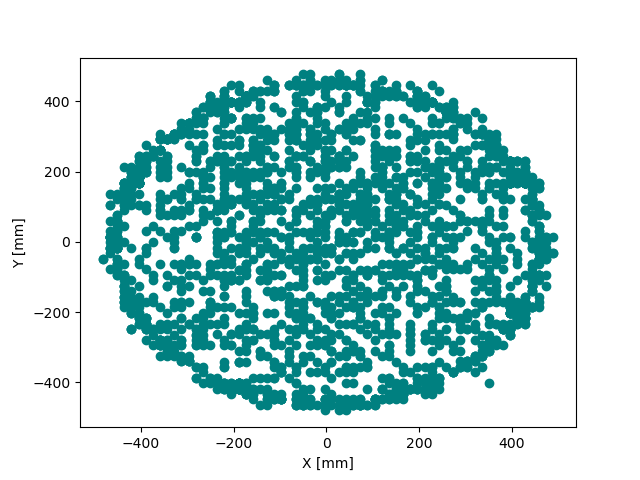

In [47]:
plt.figure()

low_E_S2 = data_properties_active_lt[data_properties_active_lt.S2_areaC < low_charge_lim]
# low_E_S2 = data_properties_active[data_properties_active.S2_area < low_charge_lim]

plt.scatter(low_E_S2.x, low_E_S2.y, color = "Teal")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")

# display(low_E_S2[low_E_S2.R < 200])


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_61641/2790404921.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis").copy()


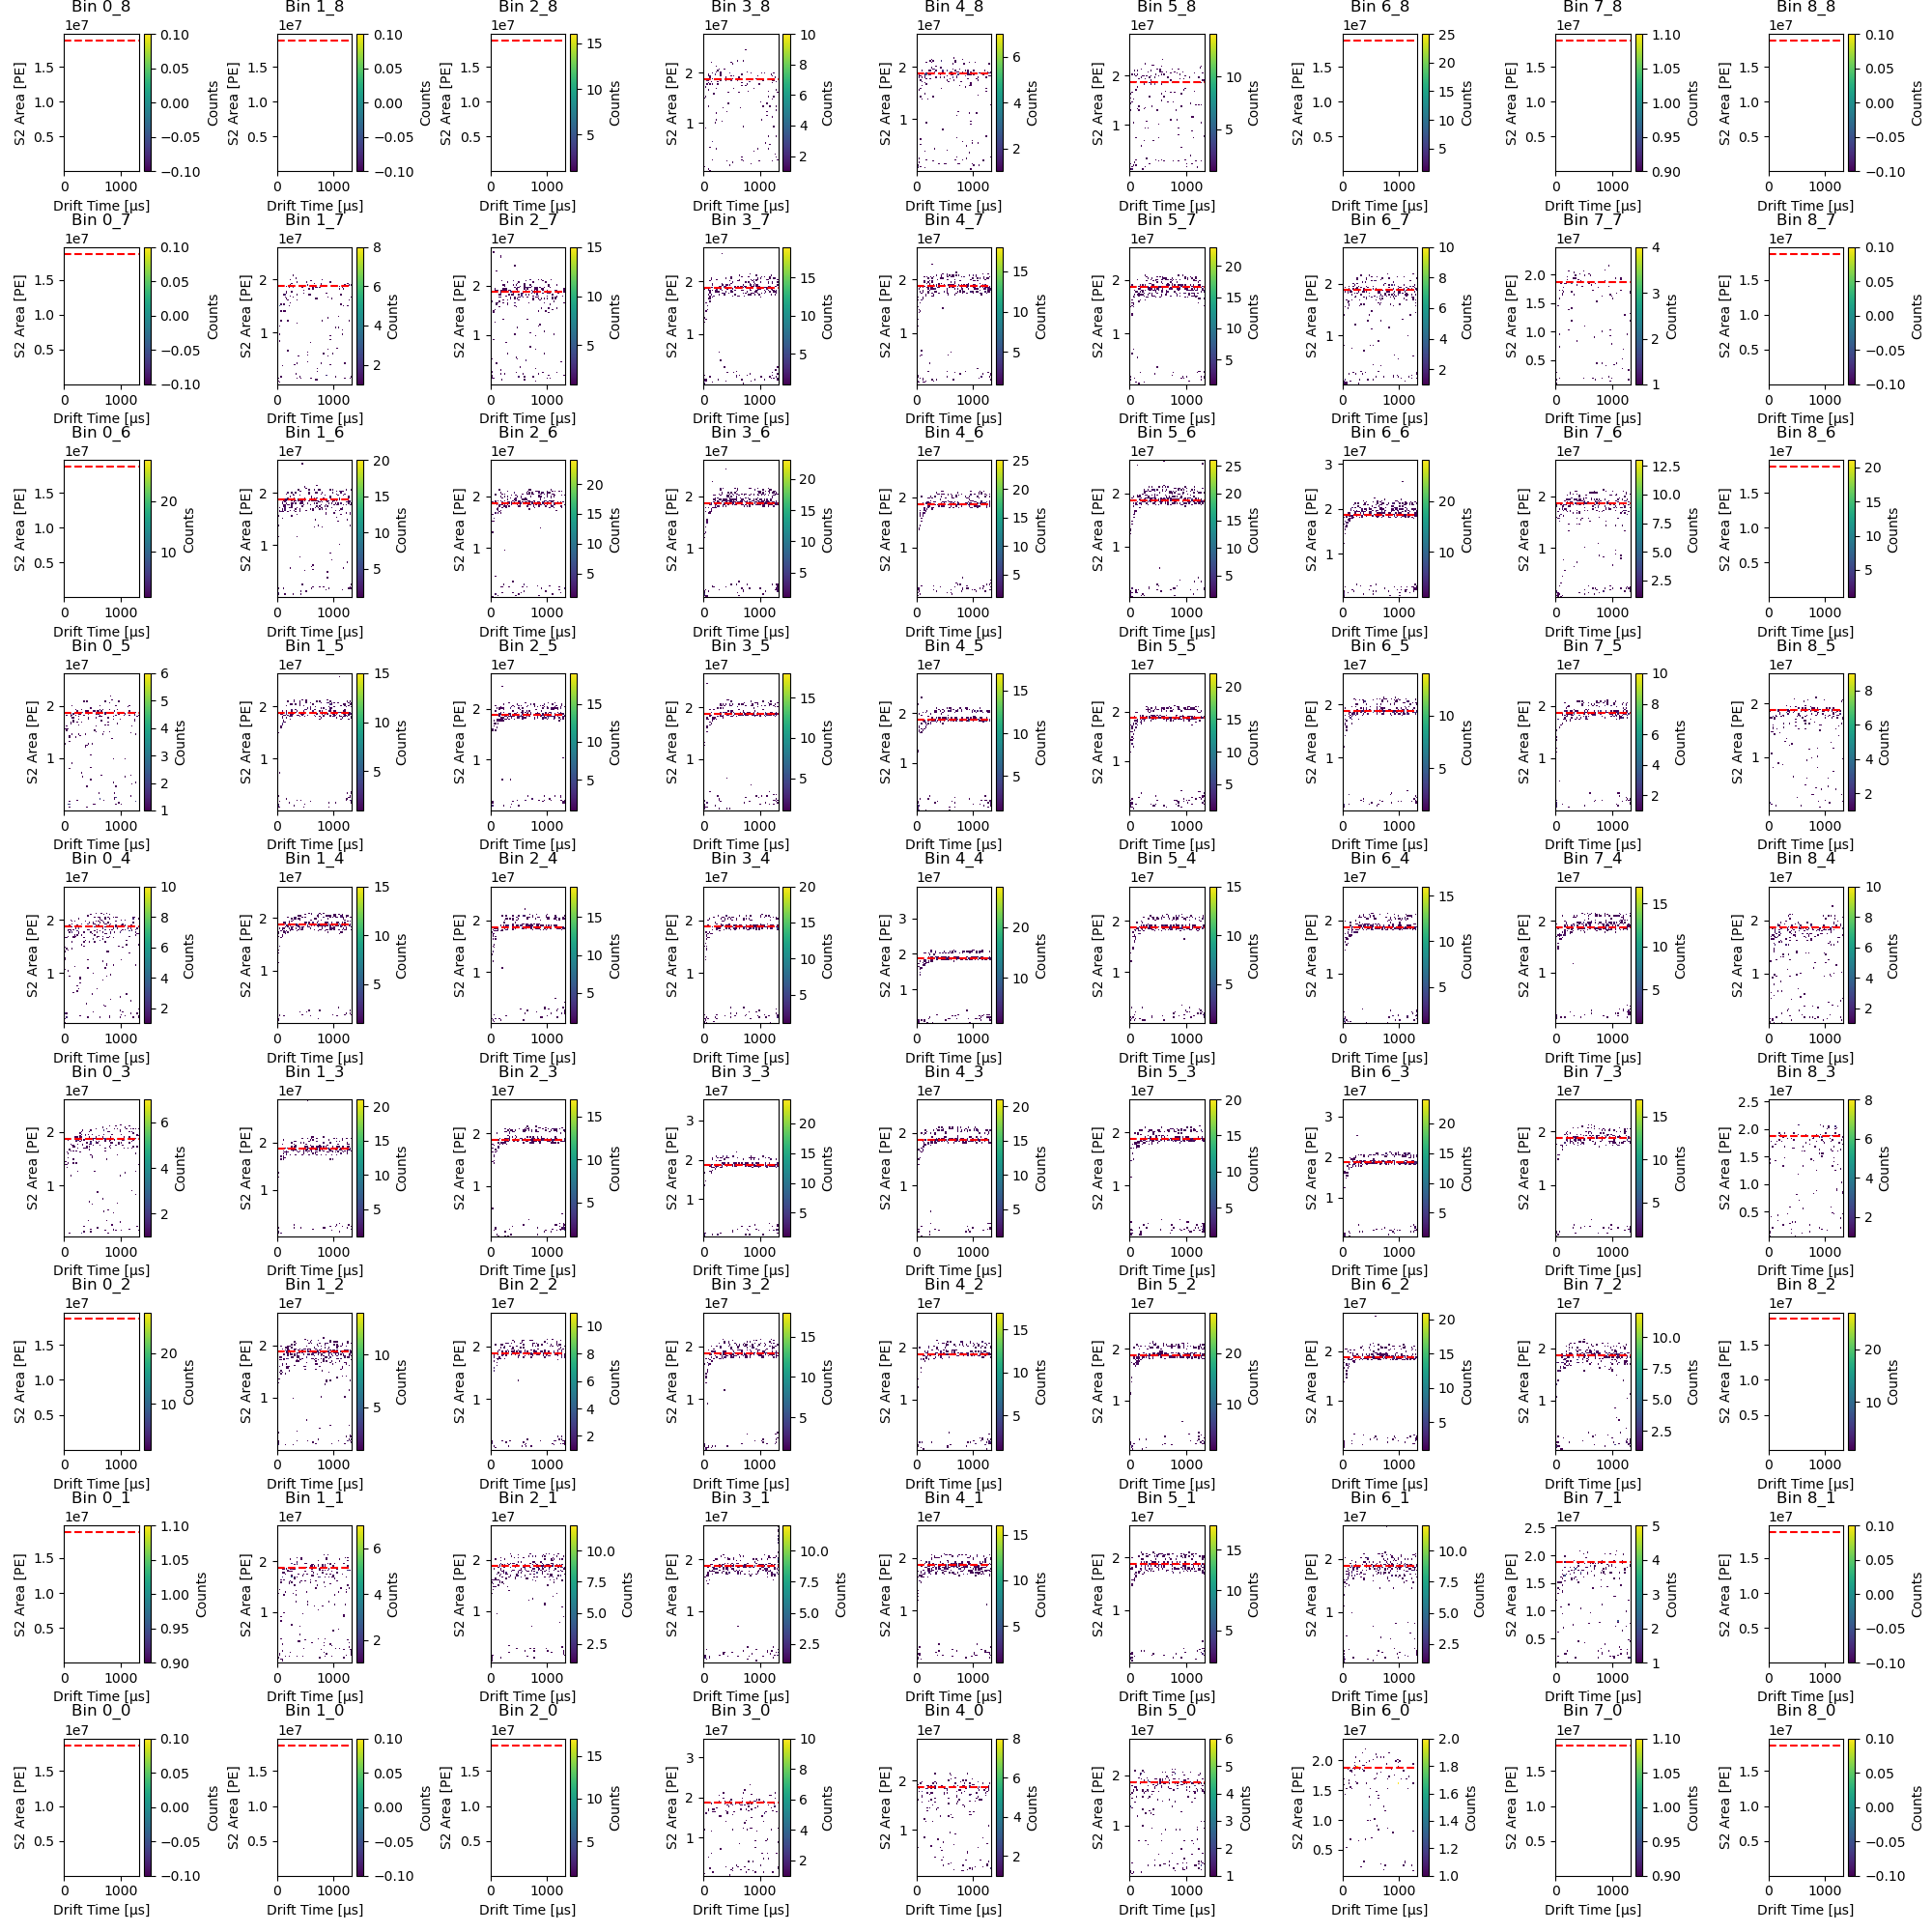

In [48]:
# Create a grid of subplots (5x5)
fig, axs = plt.subplots(nbins-1, nbins-1, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(nbins-2, -1, -1):
    for x in range(0, nbins-1, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        plot_lifetime(axs[counter], data_properties_lt, "S2_areaC",f"{x}_{y}")   
        axs[counter].set_xlim(0,cathode_cut+50)
        axs[counter].axhline(y=q0_max, color='r', linestyle='--', linewidth=1.5)
        # axs[counter].set_ylim(2.5e8,5.5e8)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [49]:
# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

# Line
def Line(x, m, c):
    return m*x+c

18.6618952834342
PE conv factor =  3.0007670255073243e-07


Text(25993354.144783344, 175, '7.7 MeV')

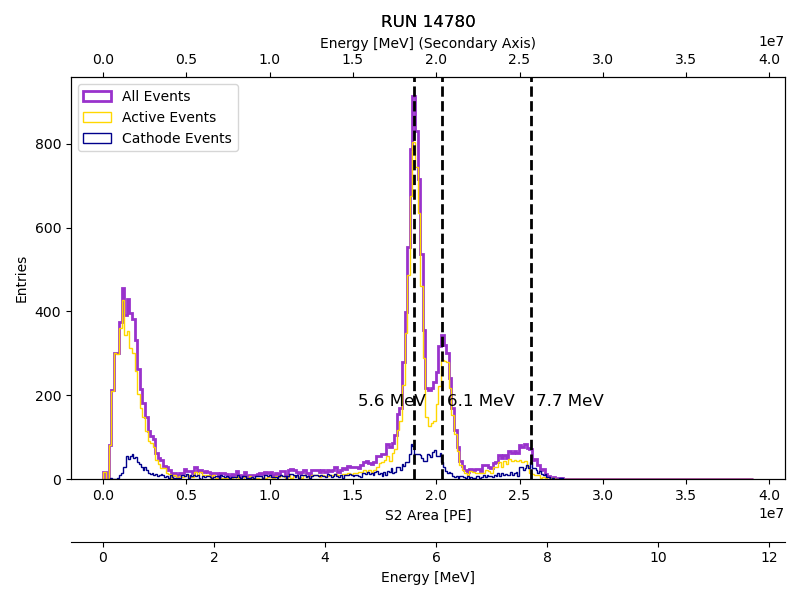

In [50]:
Radial_Cut = 350
# max_bin_shift = 0.025e7

# Histogram the S2 energy
fig, ax1 = plt.subplots(figsize = (8,6))

# data_properties_lt = data_properties_lt[ (data_properties_lt.S2_areaC < 6e7) & (data_properties_lt.S2_areaC > 1e7)]

ax1.hist(data_properties_lt[data_properties_lt.R < Radial_Cut].S2_areaC, bins = 250, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
ax1.set_xlabel("S2 Area [PE]")
ax1.set_ylabel("Entries")

# plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
counts, xbins, _ = ax1.hist(data_properties_lt[(data_properties_lt.deltaT<cathode_cut) & (data_properties_lt.R< Radial_Cut)].S2_areaC, bins = 250, histtype = "step", label="Active Events", color="gold");
ax1.hist(data_properties_lt[(data_properties_lt.deltaT>cathode_cut) & (data_properties_lt.R< Radial_Cut)].S2_areaC, bins = 250, histtype = "step", label="Cathode Events", color="DarkBlue");
ax1.legend(loc="upper left")

bin_centers = (xbins[:-1] + xbins[1:]) / 2

max_bin_index = np.argmax(counts[1:])  # Index of the bin with the most counts
max_bin_value = xbins[max_bin_index]+max_bin_shift

print(max_bin_value/1e6)
PE_to_MeV = 5.6/max_bin_value
print("PE conv factor = ", PE_to_MeV)

ax1.set_title(f"RUN {RUN}")

# Create secondary x-axis
ax2 = ax1.twiny()
ax2.set_xlabel("Energy [MeV] (Secondary Axis)")

# Set limits and fewer tick positions for the secondary x-axis
ax2.set_xlim(ax1.get_xlim())


ax2 = ax1.secondary_xaxis("bottom", functions=(lambda x: x * PE_to_MeV, lambda x: x / PE_to_MeV))
ax2.set_xlabel("Energy [MeV]")
ax2.spines['bottom'].set_position(('outward', 45))

fig.tight_layout()

# plt.hist(data_properties_lt[data_properties_lt.R < Radial_Cut].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
# plt.xlabel("S2 Area [MeV]")
# plt.ylabel("Entries")

# # plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
# counts, xbins, _ = plt.hist(data_properties_lt[(data_properties_lt.deltaT<794)& (data_properties_lt.R< Radial_Cut)].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", label="Active Events", color="gold");
# plt.hist(data_properties_lt[(data_properties_lt.deltaT>794) & (data_properties_lt.R< Radial_Cut)].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", label="Cathode Events", color="DarkBlue");
# plt.legend(loc="upper left")

ax1.axvline(5.6/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
ax1.axvline(6.1/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
ax1.axvline(7.7/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
plt.title(f"RUN {RUN}")

ax1.text(4.6/PE_to_MeV, 175, '5.6 MeV', fontsize=12)
ax1.text(6.2/PE_to_MeV, 175, '6.1 MeV', fontsize=12)
ax1.text(7.8/PE_to_MeV, 175, '7.7 MeV', fontsize=12)

# ax1.set_xlim(1.7e7,2.4e7)
# ax1.set_ylim(0,1000)


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R,cath_areaC
0,195806,1.864288e+06,1.891039e+06,1608.631760,335.670562,2543.691667,37.807753,1.738347e+09,1217.975,6.142186,...,222.222222,333.333333,6_7,72953.548827,16300460.95367,222.222222,333.333333,2.178682e+06,449.977590,342.577207
1,195813,1.628630e+07,1.668758e+07,1606.952016,227.202560,2555.748214,23.134339,1.738347e+09,170.875,2.590299,...,444.444444,111.111111,8_5,100574.161595,16424953.899536,444.444444,111.111111,1.860742e+07,415.067255,227.852686
2,195820,1.990246e+07,1.978778e+07,1614.266302,1066.971043,2558.081818,30.009613,1.738347e+09,996.650,5.689040,...,0.000000,-222.222222,4_2,129298.887466,18052998.866474,0.000000,-222.222222,2.081301e+07,170.962383,1084.902051
3,195827,1.643937e+07,1.633932e+07,1614.919970,1051.386956,2554.347368,30.625936,1.738347e+09,1350.050,6.434684,...,222.222222,-222.222222,6_2,72851.776849,18045138.622765,222.222222,-222.222222,1.738613e+07,338.059782,1075.392373
4,195834,4.006375e+06,4.000907e+06,1611.567298,229.745535,2540.197500,34.231627,1.738347e+09,849.900,5.393579,...,-333.333333,-333.333333,1_1,55237.67922,16437088.286627,-333.333333,-333.333333,4.637019e+06,452.807118,233.033976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30504,88594,1.933969e+07,1.911483e+07,1615.139968,1206.770256,2544.473171,24.738663,1.738342e+09,1101.525,5.969422,...,222.222222,-111.111111,6_3,63203.163574,18258134.665693,222.222222,-111.111111,2.019259e+07,251.270484,1229.204439
30505,88601,9.525667e+06,9.437166e+06,1608.444706,111.407851,2551.202500,26.486644,1.738342e+09,-999.000,3.452781,...,-111.111111,-444.444444,3_0,40359.657513,15210938.598717,-111.111111,-444.444444,1.144510e+07,459.160807,109.562223
30508,88622,1.896021e+07,1.898838e+07,1618.313275,912.363628,2552.725000,22.926821,1.738342e+09,1348.775,7.074120,...,444.444444,0.000000,8_4,47297.708977,16705422.804006,444.444444,0.000000,2.187763e+07,445.968375,933.174949
30509,88629,5.253151e+06,5.233413e+06,1613.070569,532.498576,2543.613158,19.137281,1.738342e+09,1349.475,6.464234,...,-222.222222,-111.111111,2_3,69606.333529,18262967.971544,-222.222222,-111.111111,5.494122e+06,277.163528,544.651423


0.023386008629897655Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 0.18662324067599187


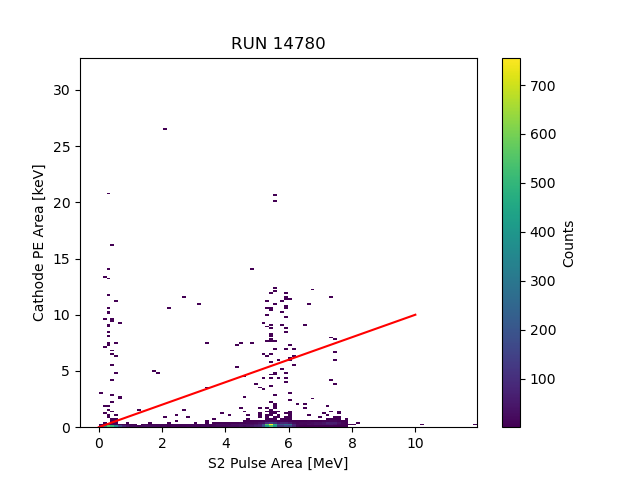

In [51]:
# 1. Create the 2D histogram

data_properties_lt = data_properties_lt[data_properties_lt.grass_peaks < 1]

display(data_properties_lt)

data_properties_lt['S2_area'] = data_properties_lt['S2_area'].fillna(0)
data_properties_lt['cath_area'] = data_properties_lt['cath_area'].fillna(0)

data_properties_lt_radial = data_properties_lt[data_properties_lt.R < 300]

# hist, xedges, yedges = np.histogram2d(data_properties_active.S2_area, data_properties_active.cath_area, bins=100)
hist, xedges, yedges = np.histogram2d(data_properties_lt_radial.S2_area*PE_to_MeV, data_properties_lt_radial.cath_area*PE_to_MeV*1000, bins=[100, 200])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("S2 Pulse Area [MeV]")
plt.ylabel("Cathode PE Area [keV]")
# plt.ylim(0,2e6)
# plt.ylim(0,2e6*PE_to_MeV*1000)

plt.title(f"RUN {RUN}")

S2_arr = np.linspace(0,10, 100)

# Perform the curve fit
# params, covariance = curve_fit(Line, data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000, bounds = ([1e8, 1e3], [4.5e8, 100e3]))
params, covariance = curve_fit(Line, data_properties_lt_radial.S2_area*PE_to_MeV, data_properties_lt_radial.cath_area*PE_to_MeV*1000)

# Extract the fitted parameters
m, c = params

print(m,c)

plt.plot(S2_arr, Line(S2_arr, 1, 0), c = "red")


In [27]:


data_properties_lt_copy = data_properties_lt.copy()

data_properties_lt_copy['S2_areaC'] = data_properties_lt_copy['S2_areaC']*PE_to_MeV
data_properties_lt_copy['cath_areaC'] = data_properties_lt_copy['cath_areaC']*PE_to_MeV
data_properties_lt_copy.to_hdf(f"../data/analysis/Properties_Run_{RUN}.h5", key='data_properties_lt', mode='w')


display(data_properties_lt_copy)

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_61641/3291657029.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['bin_id', 'lt', 'q0'], dtype='object')]

  data_properties_lt_copy.to_hdf(f"../data/analysis/Properties_Run_{RUN}.h5", key='data_properties_lt', mode='w')


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R,cath_areaC
0,195806,1.864288e+06,1.891039e+06,1608.631760,335.670562,2543.691667,37.807753,1.738347e+09,1217.975,6.142186,...,222.222222,333.333333,6_7,72953.548827,16300460.95367,222.222222,333.333333,0.657692,449.977590,0.000103
1,195813,1.628630e+07,1.668758e+07,1606.952016,227.202560,2555.748214,23.134339,1.738347e+09,170.875,2.590299,...,444.444444,111.111111,8_5,0,16424953.899536,444.444444,111.111111,0.000000,415.067255,0.000069
2,195820,1.990246e+07,1.978778e+07,1614.266302,1066.971043,2558.081818,30.009613,1.738347e+09,996.650,5.689040,...,0.000000,-222.222222,4_2,0,18052998.866474,0.000000,-222.222222,0.000000,170.962383,0.000328
3,195827,1.643937e+07,1.633932e+07,1614.919970,1051.386956,2554.347368,30.625936,1.738347e+09,1350.050,6.434684,...,222.222222,-222.222222,6_2,72851.776849,18045138.622765,222.222222,-222.222222,5.248460,338.059782,0.000325
4,195834,4.006375e+06,4.000907e+06,1611.567298,229.745535,2540.197500,34.231627,1.738347e+09,849.900,5.393579,...,-333.333333,-333.333333,1_1,55237.67922,16437088.286627,-333.333333,-333.333333,1.399806,452.807118,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30504,88594,1.933969e+07,1.911483e+07,1615.139968,1206.770256,2544.473171,24.738663,1.738342e+09,1101.525,5.969422,...,222.222222,-111.111111,6_3,63203.163574,18258134.665693,222.222222,-111.111111,6.095663,251.270484,0.000371
30505,88601,9.525667e+06,9.437166e+06,1608.444706,111.407851,2551.202500,26.486644,1.738342e+09,-999.000,3.452781,...,-111.111111,-444.444444,3_0,40359.657513,15210938.598717,-111.111111,-444.444444,3.455003,459.160807,0.000033
30508,88622,1.896021e+07,1.898838e+07,1618.313275,912.363628,2552.725000,22.926821,1.738342e+09,1348.775,7.074120,...,444.444444,0.000000,8_4,47297.708977,16705422.804006,444.444444,0.000000,6.604337,445.968375,0.000282
30509,88629,5.253151e+06,5.233413e+06,1613.070569,532.498576,2543.613158,19.137281,1.738342e+09,1349.475,6.464234,...,-222.222222,-111.111111,2_3,69606.333529,18262967.971544,-222.222222,-111.111111,1.658545,277.163528,0.000164
